<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/ML_Chapter3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 实验八：基于全连接深度神经网络模型的手写识别及Wi-Fi动作感知
湖北理工学院《机器学习》课程NoteBook

学生：吴兴平

笔记内容概述: 前馈神经网络、全连接网络、Wi-Fi动作感知

## 数据准备


载入csv数据

In [7]:
import pandas as pd

# Define training and testing files
training_files = [
    './Data/U1_G1_N30_L_L1_D0_20200408_2_Labeled.csv',
    './Data/U1_G2_N30_L_L1_D0_20200408_2_Labeled.csv',
    './Data/U1_G3_N30_L_L1_D0_20200408_2_Labeled.csv']

testing_files = [
    './Data/U1_G1_N10_L_L1_D0_20200408_1_Labeled.csv',
    './Data/U1_G2_N10_L_L1_D0_20200408_1_Labeled.csv',
    './Data/U1_G3_N10_L_L1_D0_20200408_1_Labeled.csv'
]

# Function to read and process CSV files
def read_csv_file(file_path):
    print(file_path)
    df = pd.read_csv(file_path)
    csi = df.iloc[:, 2:].values  # All columns except 'timestamp' and 'label'
    label = df['label'].values # 0: static, 1: up, 2: down, 3: left, 4: right
    timestamp = df['timestamp'].values
    print(np.unique(label))
    return csi, label, timestamp

def segment_signals(csi, label, timestamp):
    segments = [] # Store segments
    segment_label = label[0] # Initialize segment label
    segment_start = 0 # Initialize segment start index

    for i in range(len(label)): # Iterate through all labels
        if label[i] != segment_label: # If the label is different from the current segment label
            segments.append((csi[segment_start:i-1], segment_label, timestamp[segment_start:i-1])) # Append the current segment to the segments list
            segment_start = i # Update the segment start index
            segment_label = label[i] # Update the segment label

    segments.append((csi[segment_start:], segment_label, timestamp[segment_start:])) # Append the last segment to the segments list
    return segments

# Define training and testing segments
training_segments = []
testing_segments = []

# Read and process training files
for file in training_files:
    s, y, t = read_csv_file(file)
    training_segments.extend(segment_signals(s, y, t))

# Read and process testing files
for file in testing_files:
    s, y, t = read_csv_file(file)
    testing_segments.extend(segment_signals(s, y, t))

# Print sizes of the training segments and testing segments
print(f"Training segments: {len(training_segments)}")

# Print length of all training segments
for i, (s, y, t) in enumerate(training_segments):
    print(f"Training Segment {i + 1}: {len(s)}")

# Print size of the testing segments
print(f"Testing segments: {len(testing_segments)}")

./Data/U1_G1_N30_L_L1_D0_20200408_2_Labeled.csv
[0 1]
./Data/U1_G2_N30_L_L1_D0_20200408_2_Labeled.csv
[0 2]
./Data/U1_G3_N30_L_L1_D0_20200408_2_Labeled.csv
[0 3]
./Data/U1_G1_N10_L_L1_D0_20200408_1_Labeled.csv
[0 1]
./Data/U1_G2_N10_L_L1_D0_20200408_1_Labeled.csv
[0 2]
./Data/U1_G3_N10_L_L1_D0_20200408_1_Labeled.csv
[0 3]
Training segments: 183
Training Segment 1: 6414
Training Segment 2: 3504
Training Segment 3: 1214
Training Segment 4: 2960
Training Segment 5: 974
Training Segment 6: 3024
Training Segment 7: 814
Training Segment 8: 3248
Training Segment 9: 734
Training Segment 10: 2928
Training Segment 11: 782
Training Segment 12: 2480
Training Segment 13: 1102
Training Segment 14: 2656
Training Segment 15: 750
Training Segment 16: 2672
Training Segment 17: 606
Training Segment 18: 3200
Training Segment 19: 350
Training Segment 20: 3392
Training Segment 21: 878
Training Segment 22: 3136
Training Segment 23: 686
Training Segment 24: 3408
Training Segment 25: 558
Training Segment 26: 3

数据对齐：通过特征提取使得每一个训练集和测试集的样本长度相同

In [9]:
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

# Extract features of training segments
def extract_features(s):
    ''' 
    Extract features of each segment
    features include:
    - mean
    - std
    - max
    - min
    - median
    - kurtosis
    - skew
    
    Input:
    s: segment (N*30) in training_segments or testing_segments
    
    Output:
    x: 1-D vector (8*30)
    '''
    x = []
    x.extend(np.mean(s, axis=0))
    x.extend(np.std(s, axis=0))
    x.extend(np.max(s, axis=0))
    x.extend(np.min(s, axis=0))
    x.extend(np.median(s, axis=0))
    x.extend(kurtosis(s, axis=0))
    x.extend(skew(s, axis=0))

    return np.array(x)

使用extract_features创建训练集和测试集


In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def one_hot_collate(batch):
    data = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    
    one_hot_labels = torch.zeros(labels.size(0), 4)  # 4 classes
    one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)
    return data, one_hot_labels

batch_size = 4

# Build training dataset
trX = [extract_features(s) for s, _, _ in training_segments] # Extract features of training segments
trX = torch.tensor(trX, dtype=torch.float32) # Convert trX to tensor
trY = [y for _, y, _ in training_segments] # Extract labels of training segments
trY = torch.tensor(trY) # Convert trY to tensor

# Build testing dataset
teX = [extract_features(s) for s, _, _ in testing_segments] # Extract features of testing segments
teX = torch.tensor(teX, dtype=torch.float32) # Convert teX to tensor
teY = [y for _, y, _ in testing_segments] # Extract labels of testing segments
teY = torch.tensor(teY) # Convert teY to tensor

# Normalize trX and teX
# Calculate mean and standard deviation from the training data
mean = trX.mean(dim=0)
std = trX.std(dim=0)

# Normalize training data
trX = (trX - mean) / std

# Normalize testing data using training mean and std
teX = (teX - mean) / std

# Build Dataset
trDataset = TensorDataset(trX, trY) # Create training dataset
teDataset = TensorDataset(teX, teY) # Create testing dataset

# Build loader
trLoader = DataLoader(trDataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=one_hot_collate) # Create training dataloader
teLoader = DataLoader(teDataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=one_hot_collate) # Create testing dataloader

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18120\496475029.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  trX = torch.tensor(trX, dtype=torch.float32) # Convert trX to tensor


定义模型

In [12]:
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        out = self.softmax(x)
        return out

使用Adam作为Optimizor训练模型

In [13]:
# Define the model parameters
hidden_size = 10

# Instantiate the model
input_size = trX.shape[1]
num_classes = 4 # 3 movements and static
model = FNN(input_size, hidden_size, num_classes)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Lists to store losses
train_losses = []
te_losses = []

# Number of epochs
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    
    for batch_x, batch_y in trLoader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    # Calculate average training loss for this epoch
    avg_train_loss = sum(batch_losses) / len(batch_losses)
    train_losses.append(avg_train_loss)
    
    # Evaluate on cross-validation set
    model.eval()
    te_batch_losses = []
    with torch.no_grad():
        for te_x, te_y in teLoader:
            te_outputs = model(te_x)
            te_loss = criterion(te_outputs, te_y)
            te_batch_losses.append(te_loss.item())
    
    avg_te_loss = sum(te_batch_losses) / len(te_batch_losses)
    te_losses.append(avg_te_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, CV Loss: {avg_te_loss:.4f}')

FNN(
  (fc1): Linear(in_features=210, out_features=10, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=10, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch [1/200], Train Loss: 1.3246, CV Loss: 1.2515
Epoch [2/200], Train Loss: 1.1765, CV Loss: 1.0981
Epoch [3/200], Train Loss: 1.0794, CV Loss: 1.0724
Epoch [4/200], Train Loss: 1.0274, CV Loss: 1.0760
Epoch [5/200], Train Loss: 0.9919, CV Loss: 1.0855
Epoch [6/200], Train Loss: 0.9600, CV Loss: 1.0891
Epoch [7/200], Train Loss: 0.9394, CV Loss: 1.0905
Epoch [8/200], Train Loss: 0.9254, CV Loss: 1.0843
Epoch [9/200], Train Loss: 0.9137, CV Loss: 1.0730
Epoch [10/200], Train Loss: 0.9041, CV Loss: 1.0734
Epoch [11/200], Train Loss: 0.8923, CV Loss: 1.0584
Epoch [12/200], Train Loss: 0.8808, CV Loss: 1.0506
Epoch [13/200], Train Loss: 0.8712, CV Loss: 1.0309
Epoch [14/200], Train Loss: 0.8472, CV Loss: 1.0242
Epoch [15/200], Train Loss: 0.

计算精度与学习曲线

Accuracy on training set: 100.00%
Accuracy on cross-validation set: 74.60%


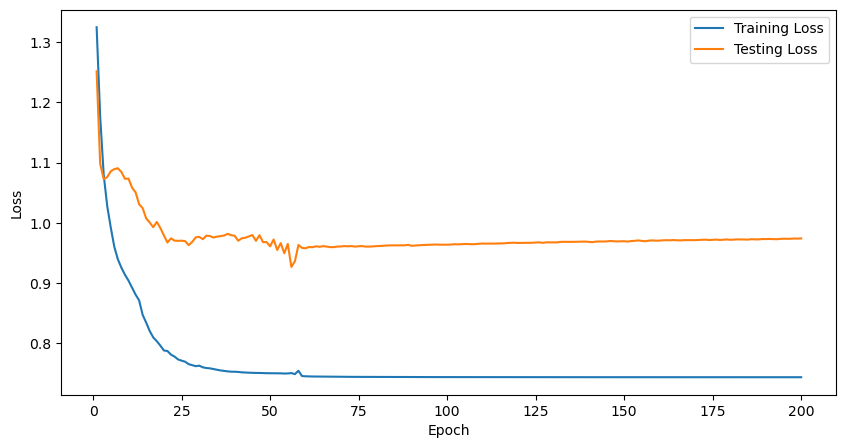

In [14]:
import matplotlib.pyplot as plt

# Calculate and print accuracies for training and cross-validation sets
model.eval()
with torch.no_grad():
    # Training set accuracy
    tr_correct = 0
    tr_total = 0
    for images, labels in trLoader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        tr_total += labels.size(0)
        tr_correct += (predicted == true_labels).sum().item()
    
    tr_accuracy = 100 * tr_correct / tr_total
    
    # test set accuracy
    te_correct = 0
    te_total = 0
    for images, labels in teLoader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        te_total += labels.size(0)
        te_correct += (predicted == true_labels).sum().item()
    
    te_accuracy = 100 * te_correct / te_total

print(f'Accuracy on training set: {tr_accuracy:.2f}%')
print(f'Accuracy on cross-validation set: {te_accuracy:.2f}%')

# Plot training and cross-validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), te_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()